## 사용 패키지

In [127]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

from sklearn.ensemble import RandomForestRegressor

from pycaret.regression import *

## 데이터 로드

In [93]:
train = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/train.csv')
test = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')
submission = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/sample_submission.csv')

temp = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/진주체감온도.csv')

In [94]:
temp.columns = ['일자','기온','풍속','체감기온']

In [95]:
train = pd.merge(train, temp)
test = pd.merge(test, temp)

## 데이터

## 요일을 숫자로 매핑

In [98]:
#train['요일'] = train['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})
#test['요일'] = test['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})

## `요일 랭크지정 방식.`
## 석식에만 적용! 석식 수요일이 자기개발의 날 때문에 적어서.

In [99]:
weekdayrankfordinner = {
    '월' : 1,
    '화' : 2,
    '수' : 5,
    '목' : 3,
    '금' : 4
} 

train['요일(석식)'] = train['요일'].map(weekdayrankfordinner)
test['요일(석식)'] = test['요일'].map(weekdayrankfordinner)

## `월, 일을 숫자형으로 변환`

In [100]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

print(train['일자'])

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.isocalendar().week
train['요일'] = train['일자'].dt.weekday


test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.isocalendar().week
test['요일'] = test['일자'].dt.weekday

train['주'] = train['주'].astype('int') # '주'의 타입이 Uint로 사용이 안되어 int로 변경해줌.
test['주'] = test['주'].astype('int')

0      2016-02-01
1      2016-02-02
2      2016-02-03
3      2016-02-04
4      2016-02-05
          ...    
1200   2021-01-20
1201   2021-01-21
1202   2021-01-22
1203   2021-01-25
1204   2021-01-26
Name: 일자, Length: 1205, dtype: datetime64[ns]


C:\ProgramData\Anaconda3\envs\py38r40\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='월', ylabel='중식계'>

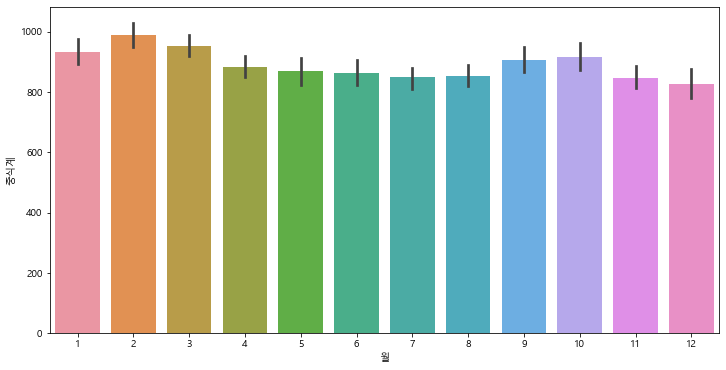

In [101]:
plt.figure(figsize=(12,6))
sns.barplot(train['월'], train['중식계'])

C:\ProgramData\Anaconda3\envs\py38r40\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='월', ylabel='석식계'>

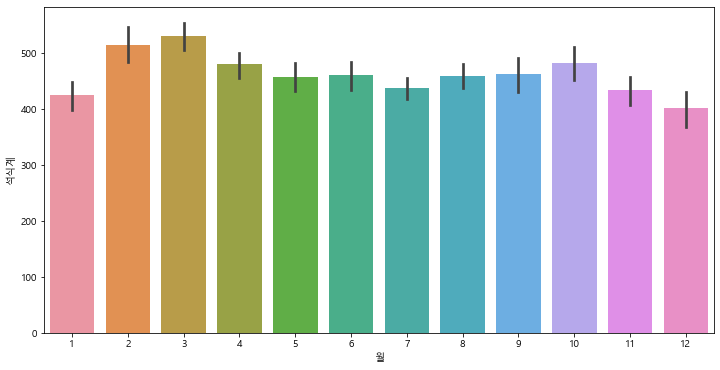

In [102]:
plt.figure(figsize=(12,6))
sns.barplot(train['월'], train['석식계'])

In [103]:
sampletrain = train.loc[:,('월','중식계','석식계')]
sampletrain.groupby(['월']).mean()

,중식계,석식계
월,,
1,934.247525,424.564356
2,989.623656,514.860215
3,953.607477,530.700935
4,883.621359,480.825243
5,869.787879,458.131313
6,863.311111,460.355556
7,848.736364,437.300000
8,854.785047,459.485981
9,907.148936,463.617021


## `월 랭크지정 방식` 낮은게 12 큰게 1 요일 랭크와 동일

In [104]:
month1 = {
    1:2,
    2:3,
    3:1,
    4:10,
    5:9,
    6:4,
    7:5,
    8:6,
    9:8,
    10:7,
    11:11,
    12:12
}

month2 = {
    1:3,
    2:2,
    3:10,
    4:4,
    5:9,
    6:6,
    7:8,
    8:5,
    9:7,
    10:11,
    11:1,
    12:12
}
train['월(중식)'] = train['월'].map(month1)
test['월(중식)'] = test['월'].map(month1)

train['월(석식)'] = train['월'].map(month2)
test['월(석식)'] = test['월'].map(month2)

train['월(중식)'] = train['월(중식)'].astype('int') # float형이라 int로 변경
test['월(중식)'] = test['월(중식)'].astype('int')
train['월(석식)'] = train['월(석식)'].astype('int')
test['월(석식)'] = test['월(석식)'].astype('int')

In [106]:
train.dtypes

일자                datetime64[ns]
요일                         int64
본사정원수                      int64
본사휴가자수                     int64
본사출장자수                     int64
본사시간외근무명령서승인건수             int64
현본사소속재택근무자수              float64
조식메뉴                      object
중식메뉴                      object
석식메뉴                      object
중식계                      float64
석식계                      float64
기온                       float64
풍속                       float64
체감기온                     float64
요일(석식)                     int64
년                          int64
월                          int64
일                          int64
주                          int32
월(중식)                      int32
월(석식)                      int32
dtype: object

## `식사가능자수`

In [109]:
train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

In [110]:
#train['중식참여율'] = train['중식계'] / train['식사가능자수']
#train['석식참여율'] = train['석식계'] / train['식사가능자수']

#test['중식참여율'] = test['중식계'] / test['식사가능자수']
#test['석식참여율'] = test['석식계'] / test['식사가능자수']

# `0708 공휴일 전후 추가 `

In [111]:
train['공휴일전후'] = 0
test['공휴일전후'] = 0

In [112]:
train['공휴일전후'][17] = 1
train['공휴일전후'][3] = 1
train['공휴일전후'][62] = 1
# train['공휴일전후'][67] = 1
# train['공휴일전후'][82] = 1
train['공휴일전후'][131] = 1
# train['공휴일전후'][130] = 1
train['공휴일전후'][152] = 1
train['공휴일전후'][226] = 1
train['공휴일전후'][221] = 1
train['공휴일전후'][224] = 1
# train['공휴일전후'][244] = 1
train['공휴일전후'][245] = 1
# train['공휴일전후'][267] = 1
train['공휴일전후'][310] = 2
train['공휴일전후'][311] = 1
train['공휴일전후'][309] = 1
train['공휴일전후'][330] = 1
train['공휴일전후'][379] = 1
train['공휴일전후'][467] = 1
# train['공휴일전후'][469] = 1
train['공휴일전후'][470] = 1
train['공휴일전후'][502] = 2
# train['공휴일전후'][501] = 1
# train['공휴일전후'][511] = 1
train['공휴일전후'][565] = 1
train['공휴일전후'][623] = 1
train['공휴일전후'][651] = 1
# train['공휴일전후'][650] = 1
train['공휴일전후'][705] = 1
# train['공휴일전후'][707] = 1
train['공휴일전후'][709] = 1
# train['공휴일전후'][733] = 1
# train['공휴일전후'][748] = 1
# train['공휴일전후'][792] = 1
train['공휴일전후'][815] = 1
train['공휴일전후'][864] = 1
# train['공휴일전후'][863] = 1
train['공휴일전후'][950] = 1
train['공휴일전후'][951] = 1
train['공휴일전후'][953] = 1
train['공휴일전후'][954] = 1
train['공휴일전후'][955] = 1
train['공휴일전후'][971] = 2
# train['공휴일전후'][970] = 1
# train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 1
train['공휴일전후'][1099] = 1
train['공휴일전후'][1129] = 1
# train['공휴일전후'][1128] = 1
train['공휴일전후'][1187] = 1
# train['공휴일전후'][1186] = 1

test['공휴일전후'][10] =2
test['공휴일전후'][20] = 1

<ipython-input-112-63b230823310>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['공휴일전후'][17] = 1
<ipython-input-112-63b230823310>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['공휴일전후'][3] = 1
<ipython-input-112-63b230823310>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['공휴일전후'][62] = 1
<ipython-input-112-63b230823310>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [113]:
# 원핫인코딩
train = pd.get_dummies(train, columns=['공휴일전후'])
test = pd.get_dummies(test, columns=['공휴일전후'])

In [114]:
test['공휴일전후_0'][20] =1
test['공휴일전후_1'][20] = 0

<ipython-input-114-c110fdca8db8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['공휴일전후_0'][20] =1
<ipython-input-114-c110fdca8db8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['공휴일전후_1'][20] = 0


## Feature

In [115]:
#x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
#y1_train = train['중식계']
#y2_train = train['석식계']

#x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

In [116]:
x1_train = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']] #중식계
x2_train = train[['요일(석식)', '본사시간외근무명령서승인건수', '식사가능자수','월(석식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']] #석식계

y1_train = train['중식계']
y2_train = train['석식계']

x1_test = test[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']]
x2_test = test[['요일(석식)', '본사시간외근무명령서승인건수', '식사가능자수', '월(석식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']]

In [117]:
# check = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '중식계', '석식계', '월', '일']]

# plt.figure(figsize=(10,10)) # 도화지 크기를 키워줌
# sns.heatmap(check.corr(), annot = True) # seaborn의 heatmap 함수에 train.corr() 상관계수를 넣어준다.
                                        # annot < 수치도 같이 나타내줌

## 점심과 저녁을 식수 인원을 예측할 2개 모델 생성

In [118]:
model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

## 학습

In [119]:
# model1.fit(x1_train, y1_train) #중식계
# model2.fit(x2_train, y2_train) #석식계

RandomForestRegressor(n_jobs=-1, random_state=42)

## 추론

In [120]:
# pred1 = model1.predict(x1_test)
# pred2 = model2.predict(x2_test)

## 결과 제출

In [121]:
# submission['중식계'] = pred1
# submission['석식계'] = pred2

In [84]:
# submission.to_csv('baseline.csv', index=False)

# `Kfold 적용 버전`

In [122]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

In [119]:
model1.fit(x1_train, y1_train) #중식계
model2.fit(x2_train, y2_train) #석식계

RandomForestRegressor(n_jobs=-1, random_state=42)

In [123]:
# model1 = cat
models1 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x1_train):
    x1_t = x1_train.iloc[train_idx]
    y1_t = y1_train.iloc[train_idx]
    x1_val = x1_train.iloc[val_idx]
    y1_val = y1_train.iloc[val_idx]
    
    models1.append(model1.fit(x1_t, y1_t))#, eval_set = (x1_val, y1_val), early_stopping_rounds=100, verbose = 100))

preds1 = []
for model1 in models1:
    preds1.append(model1.predict(x1_test))    


# model2 = cat
models2 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x2_train):
    x2_t = x2_train.iloc[train_idx]
    y2_t = y2_train.iloc[train_idx]
    x2_val = x2_train.iloc[val_idx]
    y2_val = y2_train.iloc[val_idx]
    
    models2.append(model2.fit(x2_t, y2_t))#, eval_set = (x2_val, y2_val), early_stopping_rounds=100, verbose = 100))
    

preds2 = []
for model2 in models2:
    preds2.append(model2.predict(x2_test))

In [124]:
pred1 = np.mean(preds1, axis=0)
pred2 = np.mean(preds2, axis=0)

In [125]:
submission['중식계'] = pred1
submission['석식계'] = pred2

In [126]:
submission.to_csv('baselinemonth.csv', index=False)

## `앙상블 모델 적용 버전`

In [139]:
# 메뉴
train_lunch = pd.concat([x1_train, train['중식계']], axis = 1) # concat cbind 역할
train_dinner = pd.concat([x2_train, train['석식계']], axis = 1)
test_lunch = pd.concat([x1_test], axis = 1)
test_dinner = pd.concat([x2_test], axis = 1)
print('done')

done


### 중식 모델링

In [141]:
reg = setup(data=pd.concat([x1_train,train['중식계']], axis=1), # concat cbind 역할
            target='중식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

,Description,Value
0,session_id,7968
1,Target,중식계
2,Original Data,"(1205, 10)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 13)"


In [132]:
best_5_l = compare_models(sort='MAE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,73.4542,10031.0808,99.8823,0.7711,0.1294,0.0917,1.8840
et,Extra Trees Regressor,75.3508,10316.0082,101.1803,0.7635,0.1304,0.0938,0.1860
gbr,Gradient Boosting Regressor,75.4001,10592.1825,102.4100,0.7602,0.1299,0.0935,0.0640
rf,Random Forest Regressor,77.2938,11092.4530,104.9691,0.7472,0.1351,0.0972,0.2390
lightgbm,Light Gradient Boosting Machine,78.7285,10975.2547,104.3857,0.7483,0.1342,0.0977,0.0440
knn,K Neighbors Regressor,83.8715,12487.5792,111.4885,0.7159,0.1436,0.1052,0.0230
huber,Huber Regressor,86.5504,13246.9512,114.8130,0.6968,0.1469,0.1080,0.0290
ridge,Ridge Regression,87.2951,12969.2118,113.6527,0.7030,0.1441,0.1083,0.0100
br,Bayesian Ridge,87.3072,12971.3546,113.6630,0.7029,0.1442,0.1083,0.0210
lar,Least Angle Regression,87.3183,13011.6252,113.8253,0.7018,0.1446,0.1084,0.0190


In [137]:
blended_l = blend_models(estimator_list= best_5_l, fold=5, optimize='MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)
pred_esb_l = predict_model(final_model_l, test_lunch)

pred_esb_l['Label']

submission_esb = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/sample_submission.csv')
submission_esb['중식계'] = pred_esb_l['Label']

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,81.8309,11342.5720,106.5015,0.7649,0.1287,0.0981
1,72.6695,9049.3811,95.1282,0.8058,0.1111,0.0837
2,72.3478,10254.6201,101.2651,0.7418,0.1411,0.0926
3,65.9932,8114.0598,90.0781,0.8167,0.1128,0.0810
4,78.0232,11757.2064,108.4307,0.7425,0.1504,0.1077
Mean,74.1729,10103.5679,100.2807,0.7743,0.1288,0.0926
SD,5.4031,1368.3509,6.8809,0.0314,0.0154,0.0097


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,75.2376,9475.3685,97.3415,0.7677,0.1150,0.0892


### 석식모델링

In [142]:
reg = setup(data=pd.concat([x2_train,train['석식계']], axis=1), # concat cbind 역할
            target='석식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

,Description,Value
0,session_id,6568
1,Target,석식계
2,Original Data,"(1205, 10)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 13)"


In [143]:
best_5_d = compare_models(sort = 'MAE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,59.6439,7426.1112,84.2761,0.6329,0.9119,0.1260,2.1650
lightgbm,Light Gradient Boosting Machine,62.8204,7940.6619,87.8514,0.6042,0.8792,0.1340,0.0480
gbr,Gradient Boosting Regressor,62.9957,7822.8187,87.3639,0.6105,0.9767,0.1337,0.0950
et,Extra Trees Regressor,63.5363,8337.3503,89.3329,0.5880,0.8489,0.1349,0.2300
rf,Random Forest Regressor,63.9323,8215.6259,89.1128,0.5947,0.8997,0.1362,0.3520
knn,K Neighbors Regressor,72.1703,9932.7985,98.3423,0.5074,1.0497,0.1515,0.0250
ada,AdaBoost Regressor,77.1830,10456.4231,101.5926,0.4727,1.0324,0.1636,0.0700
huber,Huber Regressor,78.0793,12891.8724,112.1434,0.3599,1.1339,0.1533,0.0370
lr,Linear Regression,80.8369,12336.3163,109.9963,0.3843,1.1065,0.1609,0.7850
lar,Least Angle Regression,80.8369,12336.3163,109.9963,0.3843,1.1065,0.1609,0.0110


In [144]:
blended_d = blend_models(estimator_list = best_5_d, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, test_dinner)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,60.3509,7640.3590,87.4091,0.6208,0.7795,0.1414
1,55.2869,5752.1446,75.8429,0.6963,0.8387,0.1124
2,62.4446,8046.0514,89.6998,0.6116,0.9457,0.1320
3,61.8943,8025.6457,89.5860,0.6024,1.1810,0.1261
4,61.6756,7937.1687,89.0908,0.5914,1.0762,0.1274
Mean,60.3305,7480.2739,86.3257,0.6245,0.9642,0.1279
SD,2.6139,876.1673,5.3051,0.0372,0.1482,0.0094


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,63.8639,8351.3775,91.3859,0.5358,0.9331,0.1515


In [145]:
pred_esb_d = predict_model(final_model_d, test_dinner)

In [146]:
submission_esb['석식계'] = pred_esb_d['Label']
submission_esb

,일자,중식계,석식계
0,2021-01-27,1018.329183,212.035499
1,2021-01-28,966.574337,489.503790
2,2021-01-29,555.428492,241.535253
3,2021-02-01,1248.319052,525.037511
4,2021-02-02,1039.225351,539.012357
5,2021-02-03,1051.095427,466.244108
6,2021-02-04,1017.052508,534.045498
7,2021-02-05,662.274892,320.725139
8,2021-02-08,1272.500290,663.319485
9,2021-02-09,1056.694148,543.074683


In [149]:
submission_esb.to_csv('ensemble.csv', index = False)

- 0708 23:11

randomforest default mae로 바꿈(대회 측정방식)->mae:73 mse:66 오히려 mse가 더 좋게나왔음..

- 0709 00:28

출장자수 변수추가했더니 1점 높게나옴. 추가할 것

- 0709 20:35
    
체감온도 추가 효과 오히려 감소

- 0709 21:38

월 매핑 -> 0.5점 상승! 체감온도는 그냥 뺐음..

- 0710 01:51

앙상블 모델 적용.
효과는 안좋았음. 테스트용으로만 써보자.

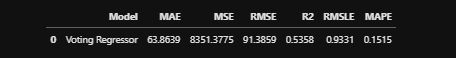